<a id="top"></a>

# King County Home Prices

---

## Project description

[King County](https://www.google.com/maps/place/King+County,+WA/@47.4269284,-122.9180846,8z/data=!3m1!4b1!4m5!3m4!1s0x54905c8c832d7837:0xe280ab6b8b64e03e!8m2!3d47.5480339!4d-121.9836029) is located in Washington and contains the Seattle metropolitan area. This project will explore the use of several regression methods in order to find the most accurate prediction of home prices in the area. Data downloaded from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction).

Some limited information is available on the [county website](http://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r), otherwise best judgement was used in interpreting the meaning of each feature in the dataset.

## Contents
1. [Exploratory data analysis](#eda)
1. [Simple model](#simple)
1. [Model including location](#loc)
1. [Time-series model](#timeseries)
1. [Combining estimators](#comb)
1. [Conclusion](#concl)

## Next steps
- Gradient boosting trees perform well here however it might be worthwhile to compare [XGBoost](https://xgboost.readthedocs.io/en/latest/) performance against the scikit-learn gradient-boosting implementation.

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(font_scale=1.25)

import os, sys
utilpath = os.path.abspath(os.path.join('..', '..', 'mypyutil'))
sys.path.append(utilpath)
# from InspectPandas import inspectdata

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline

%matplotlib inline

<a id="eda"></a>

[Return to top](#top)

---

# Exploratory data analysis

In [2]:
# load and inspect data

# df = inspectdata('kc_house_data.csv.zip')
df = pd.read_csv('kc_house_data.csv.zip', sep=',', compression='zip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


### Note:
Looks like the data provider cleaned up the dataset a bit so there aren't any missing values.

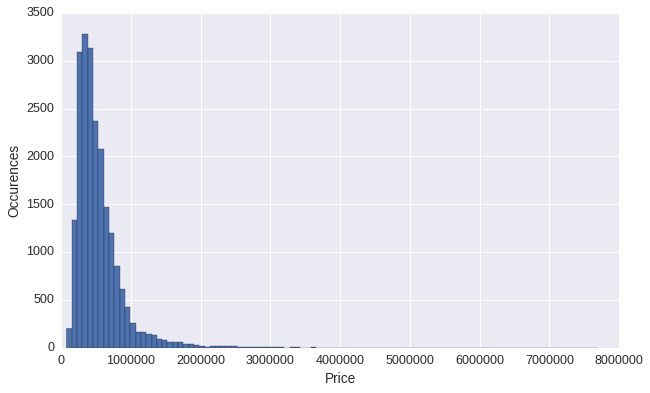

In [172]:
# distribution of prices

plt.figure(figsize=(10,6))
plt.xlabel('Price')
plt.ylabel('Occurences')
_ = df['price'].hist(bins=100)

In [173]:
# what are the categorical variables?

catvars = ['waterfront', 'view', 'condition', 'zipcode']

for var in catvars:
    print('')
    print(var)
    print(df[var].unique())


waterfront
[0 1]

view
[0 3 4 2 1]

condition
[3 5 4 1 2]

zipcode
[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]


### Note:

Based on the possible values, **condition** and **view** are likely ordinal variables. But without more information it is difficult to know with certainty.

**Waterfront** is likely a binary variable indicating if the property is on the waterfront or not, thus does not require encoding or additional processing.

Suggest checking correlation to see if variables are likely imporant.

In [174]:
# summary statistics for each of the variables

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


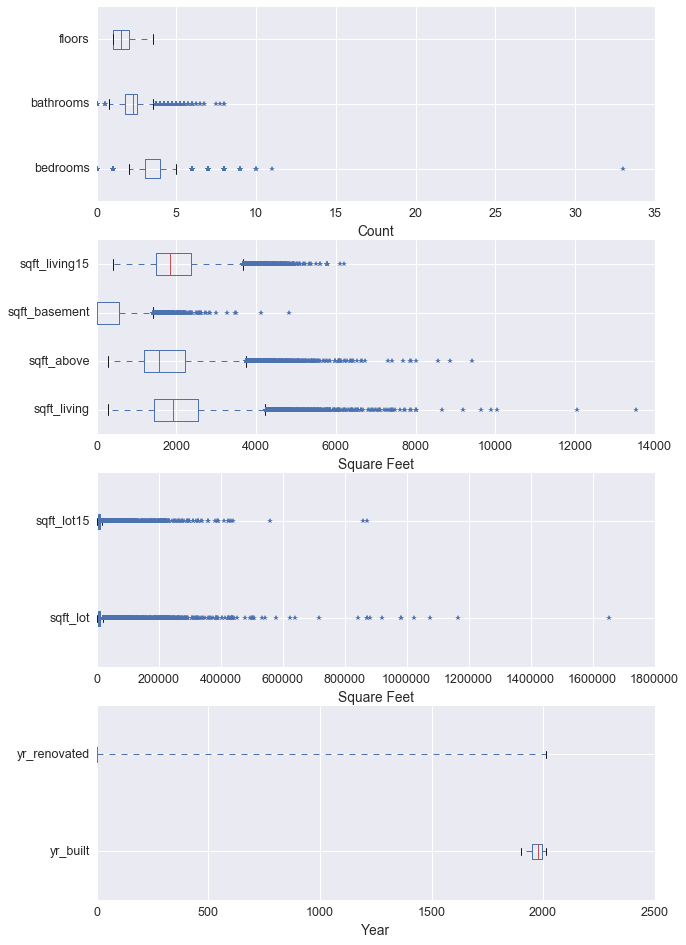

In [6]:
# check for extreme outliers or nonsensical values

f,ax = plt.subplots(4, 1, figsize=(10,16))

df[['bedrooms', 'bathrooms', 'floors']].plot(kind='box', vert=False, sym='*', ax=ax[0])

sqfts = [col for col in df.columns if 'sqft' in col and 'lot' not in col]
df[sqfts].plot(kind='box', vert=False, sym='*', ax=ax[1])

df[[col for col in df.columns if 'sqft' in col and 'lot' in col]].plot(kind='box', vert=False, sym='*', ax=ax[2])

df[[col for col in df.columns if 'yr' in col]].plot(kind='box', vert=False, sym='*', ax=ax[3])

ax[0].set_xlabel('Count')
ax[1].set_xlabel('Square Feet')
ax[2].set_xlabel('Square Feet')
ax[3].set_xlabel('Year')

### Note:

Many values for **`yr_renovated`** are zero; the most reasonable interpretation is that these houses were never renovated. Perhaps then, the features with **`15`** indicate the difference between the dimensions of the house in 2015 and as it was originally constructed?

Also 33 bedrooms seems excessive. Perhaps its a typo?

In [176]:
# exploring the 33 bedrooms house

df[df['bedrooms']==33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


### Note:

It would seem to be a typo, as if the number of bedrooms should be 3. While this would make sense intuitively, it is possible to use a quick regression model based on some obvious features (**`price`**, **`bathrooms`**, **`sqft_living`**) to see if a value of 3 is supported.

In [177]:
lr = LinearRegression()
ss = StandardScaler()
Xstd = ss.fit_transform(df[['price', 'bathrooms', 'sqft_living']])
dfXstd = pd.DataFrame(Xstd, columns=['price', 'bathrooms', 'sqft_living'])
Xstd = dfXstd.drop(15870, axis=0)
y = df['bedrooms'].drop(15870, axis=0)

lr.fit(Xstd, y)
print('Predicted bathrooms for example with 33: {0:.1f}'.format(lr.predict(dfXstd.iloc[15870].reshape(1,-1))[0]))

Predicted bathrooms for example with 33: 3.0


### Note:

So a simple linear regression model suggests the number of bedrooms for this house should be 3.

In [178]:
# set bedrooms to 3 for mistaken value

df.set_value(15870, 'bedrooms', 3)
df[df.id == 2402100895]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,3,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [179]:
# examining the other variables...
# what are the changes over time for living space and lot size for non-renovated houses?

df['livingdiff'] = df['sqft_living15'] - df['sqft_living']
df['lotdiff'] = df['sqft_lot15'] - df['sqft_lot']
df[['livingdiff', 'lotdiff']][df['yr_renovated']==0].describe()

,livingdiff,lotdiff
count,20699.000000,2.069900e+04
mean,-82.317745,-2.316542e+03
std,585.238849,2.912757e+04
min,-8690.000000,-1.225778e+06
25%,-290.000000,-6.700000e+02
50%,0.000000,0.000000e+00
75%,220.000000,4.150000e+02
max,2310.000000,3.268790e+05


In [180]:
# differences for renovated houses?

df[['livingdiff', 'lotdiff']][df['yr_renovated']!=0].describe()

,livingdiff,lotdiff
count,914.000000,914.000000
mean,-343.128009,-2836.050328
std,845.506489,23496.634059
min,-8110.000000,-280213.000000
25%,-780.000000,-1099.000000
50%,-215.000000,0.000000
75%,123.000000,632.000000
max,1960.000000,208216.000000


In [181]:
# do all values with non-zero renovation year, have renovation after year built?

all(df[df['yr_renovated']!=0].index == df[df['yr_renovated']>df['yr_built']].index)

True

In [182]:
# how does the renovation year influence price?

df[['yr_renovated','price']][df['yr_renovated']!=0].corr()

,yr_renovated,price
yr_renovated,1.000000,0.127894
price,0.127894,1.000000


In [183]:
# what about if a renovation is performed?

df['is_renovated'] = df['yr_renovated'].apply(lambda x: int(x>0))
df[['is_renovated', 'price']].corr()

,is_renovated,price
is_renovated,1.000000,0.126092
price,0.126092,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.17
Date:                Thu, 06 Oct 2016   Prob (F-statistic):           0.000106
Time:                        15:08:48   Log-Likelihood:                -13461.
No. Observations:                 914   AIC:                         2.693e+04
Df Residuals:                     912   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -9.237e+06   2.57e+06     -3.598      0.000     -1.43e+07  -4.2e+06
yr_renovated  5009.0285   1286.248      3.894      0.000      2484.679  7533.378
==============================================================================
Omnibus:                      880.533   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50308.616
Skew:                           4.306   Prob(JB):                         0.00
Kurtosis:                      38.311   Cond. No.                     2.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

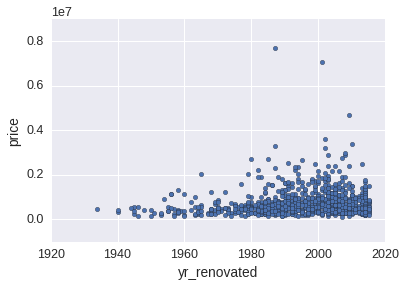

In [184]:
# is the relationship statistically significant?

dfrenov = df[['yr_renovated', 'price']][df['yr_renovated']!=0]
dfrenov.plot(x='yr_renovated', y='price', kind='scatter')

smf.ols('price ~ yr_renovated', data=dfrenov).fit().summary()

In [185]:
# create new yr_renovated feature where zeros are replaced with NaNs then imputed with the mean

yrmean = df['yr_renovated'][df['yr_renovated']!=0].mean()

def yrreplace(x):
    if x==0:
        return yrmean
    else:
        return x

df['yr_renovated_new'] = df['yr_renovated'].apply(yrreplace)

df['yr_renovated_new'].head()

0    1995.827133
1    1991.000000
2    1995.827133
3    1995.827133
4    1995.827133
Name: yr_renovated_new, dtype: float64

### Note:

1. So the dataset is consistent in that non-zero **`yr_renovation`** values have a renovation date after the build date. 
1. The living and lot size can increase or decrease with our without a renovation.
1. There is a moderate correlation between renovation date and price. More recent renovations are correlated with a higher price. Additionally, there is a correlation of the same magnitude between whether or renovation was performed or not.
1. More recent renovations seem to be associated with a higher sale price.

In [188]:
# save progress
df.to_csv('modified01.csv.gz', sep=',', index=False, compression='gzip')

<a id="simple"></a>

[Return to top](#top)

---

# Model with little data processing

Does not include time or location features.

In [140]:
# load saved data

df = pd.read_csv('modified01.csv.gz', sep=',', compression='gzip')

In [141]:
# check for correlation with price for appropriate variables
# drop unexamined variables and any that we can't interpret

exclvars = ['id', 'zipcode', 'lat', 'long', 'date', 'livingdiff', 'lotdiff', 'yr_renovated']

dfcont = df.drop(exclvars, axis=1)

dfcont.corr()[['price']].sort_values(by='price', ascending=False)

,price
price,1.000000
sqft_living,0.702035
grade,0.667434
sqft_above,0.605567
sqft_living15,0.585379
bathrooms,0.525138
view,0.397293
sqft_basement,0.323816
bedrooms,0.315438
waterfront,0.266369


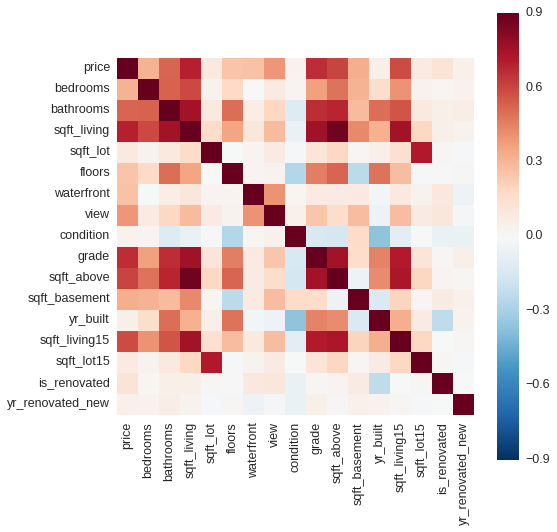

In [142]:
# overall correlation

f, ax = plt.subplots(figsize=(8,8))
_ = sns.heatmap(dfcont.corr(), vmax=0.9, square=True)

### Note

Regularization will be used to address potential collinearity.

In [143]:
# split dataset and standardize

y = dfcont['price']
Xraw = dfcont.drop('price', axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [144]:
# ridge regression with standardized values

ridge = RidgeCV(alphas=np.logspace(-5,5,11), cv=None, scoring=None)
ridge.fit(Xtrain, ytrain)

print('alpha = {0:.2g}'.format(ridge.alpha_))
pd.Series(ridge.coef_, index=Xraw.columns).sort_values(ascending=False)

alpha = 10


grade               136271.693741
sqft_living          76840.871645
sqft_above           65285.541808
waterfront           47883.962826
bathrooms            37594.630662
sqft_basement        37307.641300
view                 33871.012618
sqft_living15        17799.935025
floors               14644.538164
condition            10882.287198
yr_renovated_new      9653.126841
is_renovated          5435.162748
sqft_lot             -1588.446844
sqft_lot15          -13989.784382
bedrooms            -39515.895813
yr_built           -105496.582157
dtype: float64

In [145]:
# lasso regression with standardized values

lasso = LassoCV(n_alphas=100, cv=5)
lasso.fit(Xtrain, ytrain)

print('alpha = {0:.2g}'.format(lasso.alpha_))

pd.Series(lasso.coef_, index=Xraw.columns).sort_values(ascending=False)

alpha = 2.5e+02


sqft_living         149140.804424
grade               136467.897524
waterfront           47724.947388
bathrooms            37265.138167
view                 33902.635460
sqft_living15        17390.495159
floors               14207.720057
condition            10602.023611
yr_renovated_new      9376.714018
is_renovated          5279.176220
sqft_basement         2177.456860
sqft_above               0.000000
sqft_lot             -1376.569794
sqft_lot15          -13832.144020
bedrooms            -38855.827717
yr_built           -105136.913248
dtype: float64

In [13]:
# run random forest regressor

rf = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [500,1000], 'max_depth': [16,32]}

grid = GridSearchCV(rf, params, n_jobs=1)
grid.fit(Xtrain, ytrain)
print(grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [14]:
griddf = pd.DataFrame(grid.cv_results_)
griddf['mean_test_score'].max()

0.74759933690336489

In [184]:
# run gradient boosting regressor

# gbr = GradientBoostingRegressor()
# params = {'n_estimators': [50,100,150,200], 'max_depth': [4,8,12,16]}

# gridgbr = GridSearchCV(gbr, params, n_jobs=-1)
# gridgbr.fit(Xtrain, ytrain)
# print(gridgbr.best_estimator_)

In [185]:
# gridgbrdf = pd.DataFrame(gridgbr.cv_results_)
# gridgbrdf['mean_test_score'].describe()

In [15]:
# support vector machine regressor

svm = SVR(kernel='rbf')
params = {'C': np.logspace(-1,6,8)}

gridsvm = GridSearchCV(svm, params, scoring='r2', n_jobs=-1)
gridsvm.fit(Xtrain, ytrain)
print(gridsvm.best_estimator_)

SVR(C=1000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
  verbose=False)


In [16]:
griddf = pd.DataFrame(gridsvm.cv_results_)
griddf['mean_test_score'].max()

0.68421442681919598

In [17]:
# compare test set error

regs = [ridge, lasso, grid, gridsvm]
names = ['ridge','lasso', 'random forest', 'svm']

for reg, name in zip(regs, names):
    print(name+' r^2:')
    print('{0:.3f}'.format(r2_score(ytest, reg.predict(Xtest))))
    print('')

ridge r^2:
0.66

lasso r^2:
0.66

random forest r^2:
0.729

svm r^2:
0.705



<a id="loc"></a>

[Return to top](#top)

---
# Model including sale location

Previously random forest regression proved the best so we will continue with that regressor and see if we can improve the model performance.

In [146]:
# load saved data

df = pd.read_csv('modified01.csv', sep=',', compression='gzip')

In [147]:
# keep lat/long for location since it is more granular than zip code

exclvars = ['id', 'zipcode', 'date', 'livingdiff', 'lotdiff', 'yr_renovated']

dfloc = df.drop(exclvars, axis=1)
dfloc.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'is_renovated', 'yr_renovated_new'],
      dtype='object')

In [148]:
# split dataset and standardize non-categorical variables (standardize categorical variables have any effect?)

y = dfloc['price']
Xraw = dfloc.drop(['price'], axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

# run random forest regressor

rf2 = RandomForestRegressor(random_state=42, n_jobs=-1)
params = {'n_estimators': [1000,3000], 'max_depth': [8,16], 'max_features': ['sqrt',0.5]}

gridrf2 = GridSearchCV(rf2, params, scoring='r2', n_jobs=1)
gridrf2.fit(Xtrain, ytrain)

# display results

print(gridrf2.best_params_)
griddf = pd.DataFrame(gridrf2.cv_results_)
print('')
print('training set r^2 score = {0:.4f}'.format(griddf['mean_test_score'].max()))

print('')
print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, gridrf2.predict(Xtest))))

{'max_features': 0.5, 'max_depth': 16, 'n_estimators': 1000}

training set r^2 score = 0.8684

test set r^2 score = 0.8631


In [149]:
for row in griddf[['params','mean_test_score']].values:
    print(row[0], '  ', '{0:.4f}'.format(row[1]))

{'max_features': 'sqrt', 'max_depth': 8, 'n_estimators': 1000}    0.8193
{'max_features': 'sqrt', 'max_depth': 8, 'n_estimators': 3000}    0.8194
{'max_features': 0.5, 'max_depth': 8, 'n_estimators': 1000}    0.8409
{'max_features': 0.5, 'max_depth': 8, 'n_estimators': 3000}    0.8407
{'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 1000}    0.8571
{'max_features': 'sqrt', 'max_depth': 16, 'n_estimators': 3000}    0.8574
{'max_features': 0.5, 'max_depth': 16, 'n_estimators': 1000}    0.8684
{'max_features': 0.5, 'max_depth': 16, 'n_estimators': 3000}    0.8683


### Note:

At **`test_size=0.25`** and **`test_size=0.4`** with different random seeds for the train/test split, test error values are very similar.

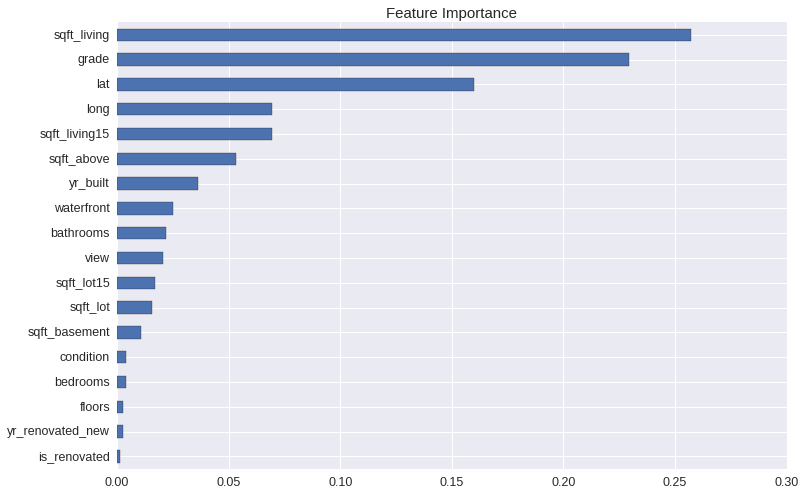

In [150]:
# feature importance

featimp = pd.Series(gridrf2.best_estimator_.feature_importances_, index=Xraw.columns)
plt.figure(figsize=(12,8))
plt.title('Feature Importance')
_ = featimp.sort_values(ascending=True).plot(kind='barh')

Best parameters:
{'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000}

training set r^2 score = 0.8870

test set r^2 score = 0.8898


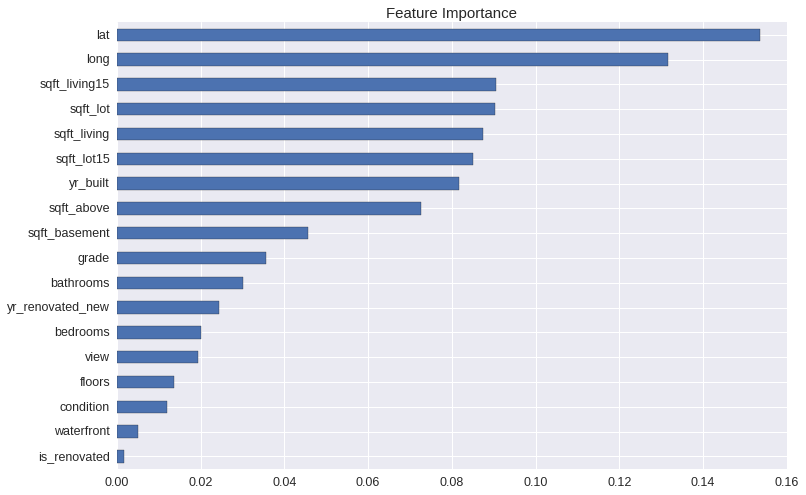

In [163]:
# gradient boosting trees

# split dataset and standardize non-categorical variables (standardize categorical variables have any effect?)

y = dfloc['price']
Xraw = dfloc.drop(['price'], axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

# run random forest regressor

gbr = GradientBoostingRegressor(random_state=42)
params = {'n_estimators': [1000,2000], 'max_depth': [2,4,8], 'learning_rate': [0.1,0.01,0.001]}

gridgbr = GridSearchCV(gbr, params, scoring='r2', n_jobs=-1)
gridgbr.fit(Xtrain, ytrain)

# display results

print('Best parameters:')
print(gridgbr.best_params_)
gridgbrdf = pd.DataFrame(gridgbr.cv_results_)
print('')
print('training set r^2 score = {0:.4f}'.format(gridgbrdf['mean_test_score'].max()))

print('')
print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, gridgbr.predict(Xtest))))

# feature importance

featimp = pd.Series(gridgbr.best_estimator_.feature_importances_, index=Xraw.columns)
plt.figure(figsize=(12,8))
plt.title('Feature Importance')
_ = featimp.sort_values(ascending=True).plot(kind='barh')

## Result

Interestingly, the location is by far the most important feature so its inclusion is critical. The Gradient-Boosted model performs better than the Random Forest algorithm previously used.

<a id="timeseries"></a>

[Return to top](#top)

---
# Modeled as a time series

Determine range of time spanned by data and appropriate granularity (day, week, month, year).

In [57]:
# extract year and month from date

df['saleyear'] = pd.to_datetime(df['date']).dt.year
df['salemonth'] = pd.to_datetime(df['date']).dt.month

df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,livingdiff,lotdiff,yr_renovated_new,saleyear,salemonth
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,98178,47.5112,-122.257,1340,5650,160,0,1995.827133,2014,10
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,98125,47.7210,-122.319,1690,7639,-880,397,1991.000000,2014,12
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,98028,47.7379,-122.233,2720,8062,1950,-1938,1995.827133,2015,2
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,98136,47.5208,-122.393,1360,5000,-600,0,1995.827133,2014,12
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,98074,47.6168,-122.045,1800,7503,120,-577,1995.827133,2015,2


In [58]:
# correlation between saleyear, salemonth and price?

df[['saleyear', 'salemonth', 'price']].corr().price

saleyear     0.003576
salemonth   -0.010081
price        1.000000
Name: price, dtype: float64

In [59]:
# number of 2014 and 2015 house sales

print('2014 records:', len(df[df['saleyear']==2014]))
print('2015 records:', len(df[df['saleyear']==2015]))

2014 records: 14633
2015 records: 6980


In [60]:
# are all months present for each year?

print(pd.to_datetime(df['date']).min())
print(pd.to_datetime(df['date']).max())

2014-05-02 00:00:00
2015-05-27 00:00:00


### Note:
Data only spans a single year. So yearly time groups don't make sense; test day, week, month.

In [151]:
# load data for model construction

df = pd.read_csv('modified01.csv', sep=',', compression='gzip')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,livingdiff,lotdiff,is_renovated,yr_renovated_new
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,160,0,0,1995.827133
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,-880,397,1,1991.000000
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,1950,-1938,0,1995.827133
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,-600,0,0,1995.827133
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,120,-577,0,1995.827133


In [22]:
# first convert date to proper date

df['date'] = pd.to_datetime(df['date'])
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,livingdiff,lotdiff,is_renovated,yr_renovated_new
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,160,0,0,1995.827133
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,-880,397,1,1991.000000
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,1950,-1938,0,1995.827133
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,-600,0,0,1995.827133
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,120,-577,0,1995.827133


In [23]:
# function to generate proper time stamps based on desired granularity


# find earliest time points and save for proper time window
df2014 = df[df['date'].dt.year==2014]
firstmonth = df2014['date'].dt.month.min()
firstweek = df2014['date'][df2014['date']<pd.to_datetime('2014-12-29')].dt.weekofyear.min()
firstday = df2014['date'].dt.dayofyear.min()

print(firstmonth, firstweek, firstday)

# all of these quantities (day, week, month) are 1-indexed
def ordinalconv(row, timeframe):
    if timeframe == 'month':
        first = firstmonth
        last = 12
        currow = row.month
    elif timeframe == 'week':
        first = firstweek
        last = 52
        currow = row.weekofyear
    elif timeframe == 'day':
        first = firstday
        last = 365
        currow = row.dayofyear
    else:
        return np.nan
    return currow + (row.year - 2014)*last - first

5 18 122


In [166]:
# compute the performance for each time delta and return best

# first sort values to preserve date order
df.sort_values(by='date', ascending=True, inplace=True)

# add appropriate time stamp
for timedelta in ['month', 'week', 'day']:
    df['timedelta'] = df['date'].apply(ordinalconv, args=(timedelta,))
    
    # compute model
    trainmask = df['date'].dt.year==2014
    testmask = df['date'].dt.year==2015
        
    exclvars = ['id', 'zipcode', 'date', 'livingdiff', 'lotdiff', 'yr_renovated']
    dftime = df.drop(exclvars, axis=1, inplace=False)
    
    y = dftime['price']
    Xraw = dftime.drop(['price'], axis=1)

    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(Xraw), index=Xraw.index)
    
    Xtrain = X[trainmask]
    Xtest = X[testmask]
    ytrain = y[trainmask]
    ytest = y[testmask]
    
    print('')
    print(timedelta)
    
    gbr = GradientBoostingRegressor(n_estimators=1000, max_depth=4, random_state=42)
    params = {'learning_rate': [1,0.1,0.01]}

    gridgbrtime = GridSearchCV(gbr, params, scoring='r2', cv=TimeSeriesSplit(n_splits=3), n_jobs=-1)
    gridgbrtime.fit(Xtrain, ytrain)

    # display results

    print(gridgbrtime.best_params_)
    gridgbrtimedf = pd.DataFrame(gridgbrtime.cv_results_)
    print('training set r^2 score = {0:.4f}'.format(gridgbrtimedf['mean_test_score'].max()))
    print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, gridgbrtime.predict(Xtest))))


month
{'learning_rate': 0.1}
training set r^2 score = 0.9019
test set r^2 score = 0.8769

week
{'learning_rate': 0.1}
training set r^2 score = 0.9014
test set r^2 score = 0.8688

day
{'learning_rate': 0.1}
training set r^2 score = 0.8978
test set r^2 score = 0.8754


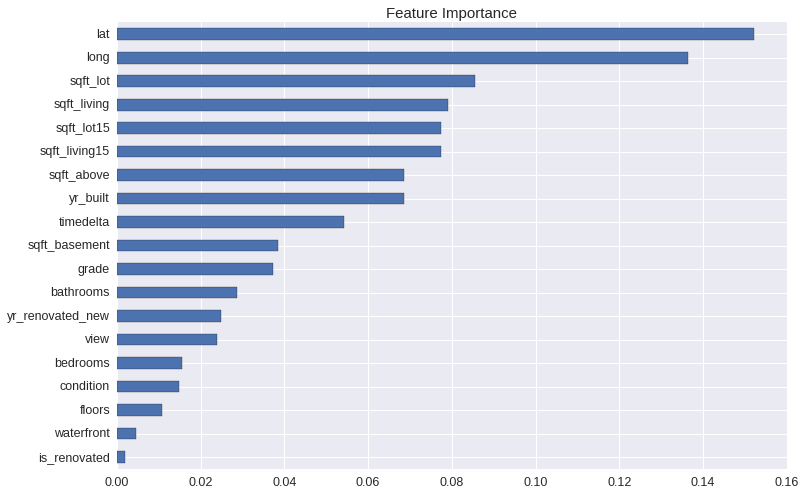

In [167]:
# feature importance

featimp = pd.Series(gridgbrtime.best_estimator_.feature_importances_, index=Xraw.columns)
plt.figure(figsize=(12,8))
plt.title('Feature Importance')
_ = featimp.sort_values(ascending=True).plot(kind='barh')

## Result

There is actually a slight decrease in model performance when considering the time evolution of this data. This could be a result of slight overfitting, as training performance increases while test performance decreases which is consistent with a loss of generalizability.

[Return to top](#top)

<a id="comb"></a>

---

# Combination of predictions

Although the gradient boosting model seems to generalize well (test error is close in magnitude to training error) it may be possible to improve performance by combining the output of several models.

In [5]:
# load dataset

df = pd.read_csv('modified01.csv.gz', sep=',', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 25 columns):
id                  21613 non-null int64
date                21613 non-null object
price               21613 non-null float64
bedrooms            21613 non-null int64
bathrooms           21613 non-null float64
sqft_living         21613 non-null int64
sqft_lot            21613 non-null int64
floors              21613 non-null float64
waterfront          21613 non-null int64
view                21613 non-null int64
condition           21613 non-null int64
grade               21613 non-null int64
sqft_above          21613 non-null int64
sqft_basement       21613 non-null int64
yr_built            21613 non-null int64
yr_renovated        21613 non-null int64
zipcode             21613 non-null int64
lat                 21613 non-null float64
long                21613 non-null float64
sqft_living15       21613 non-null int64
sqft_lot15          21613 non-null int64
livingdiff         

In [18]:
# divide dataset

y = df['price']
Xraw = df.drop(['price', 'livingdiff', 'lotdiff', 'id', 'date', 'zipcode'], axis=1)

ss = StandardScaler()
X = ss.fit_transform(Xraw)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=1)

In [11]:
# run random forest regressor

rfparams = {'max_features': 0.5, 'max_depth': 16, 'n_estimators': 1000}

rf = RandomForestRegressor(random_state=42, n_jobs=-1, **rfparams)
rf.fit(Xtrain, ytrain)

# run gradient boosting regressor

gbrparams = {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 1000}

gbr = GradientBoostingRegressor(random_state=42, **gbrparams)
gbr.fit(Xtrain, ytrain)

# combine outputs and feed into linear regression

lr = LinearRegression(n_jobs=-1)
lr.fit(np.hstack((rf.predict(Xtrain).reshape(-1,1),gbr.predict(Xtrain).reshape(-1,1))),ytrain)

for name,est in zip(['Random Forest', 'Gradient Boosting', 'Linear Combination'],[rf,gbr,lr]):
    print(name)
    if est==lr:
        Xtest = np.hstack((rf.predict(Xtest).reshape(-1,1),gbr.predict(Xtest).reshape(-1,1)))
    ypred = est.predict(Xtest)
    print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, ypred)))
    print()

Random Forest
test set r^2 score = 0.8622

Gradient Boosting
test set r^2 score = 0.8909

Linear Combination
test set r^2 score = 0.8826



In [12]:
# random forest is first coefficient, gradient-boosting is second

print(lr.coef_, lr.intercept_)

[ 0.68288552  0.35602931] -20861.3317673


In [13]:
# add in support vector machines as well

svm = SVR(kernel='rbf')
params = {'C': np.logspace(-1,6,8)}

gridsvm = GridSearchCV(svm, params, scoring='r2', n_jobs=-1)
gridsvm.fit(Xtrain, ytrain)
print(gridsvm.best_params_)

{'C': 1000000.0}


In [19]:
# result with all 3 estimators

lr.fit(np.hstack((rf.predict(Xtrain).reshape(-1,1), 
                  gbr.predict(Xtrain).reshape(-1,1), 
                  gridsvm.predict(Xtrain).reshape(-1,1))), ytrain)

Xtest3 = np.hstack((rf.predict(Xtest).reshape(-1,1), 
                  gbr.predict(Xtest).reshape(-1,1), 
                  gridsvm.predict(Xtest).reshape(-1,1)))

print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, lr.predict(Xtest3))))

test set r^2 score = 0.8866


In [20]:
# random forest is first coefficient, gradient-boosting is second, svm is third

print(lr.coef_, lr.intercept_)

[ 0.88936674  0.34469522 -0.22120925] -9360.24042484


In [31]:
# factor in time dependence

# first sort values to preserve date order
df.sort_values(by='date', ascending=True, inplace=True)

trainmask = df['date'].dt.year==2014
testmask = df['date'].dt.year==2015

X = pd.DataFrame(ss.fit_transform(Xraw), index=Xraw.index)

Xtrain = X.loc[trainmask]
Xtest = X.loc[testmask]
ytrain = y.loc[trainmask]
ytest = y.loc[testmask]

df['timedelta'] = df['date'].apply(ordinalconv, args=('month',))

svm.set_params(C=1000000.0)

for name,est in zip(['Random Forest', 'Gradient Boosting', 'SVM', 'Linear Combination'],[rf,gbr,svm,lr]):
    print(name)
    if est==lr:
        est.fit(np.hstack((rf.predict(Xtrain).reshape(-1,1), 
                           gbr.predict(Xtrain).reshape(-1,1), 
                           gridsvm.predict(Xtrain).reshape(-1,1))), ytrain)
        Xtest3 = np.hstack((rf.predict(Xtest).reshape(-1,1), 
                           gbr.predict(Xtest).reshape(-1,1), 
                           gridsvm.predict(Xtest).reshape(-1,1)))
    else:
        est.fit(Xtrain, ytrain)
        Xtest3 = Xtest
    ypred = est.predict(Xtest3)
    print('test set r^2 score = {0:.4f}'.format(r2_score(ytest, ypred)))
    print()

Random Forest
test set r^2 score = 0.8585

Gradient Boosting
test set r^2 score = 0.8704

SVM
test set r^2 score = 0.7941

Linear Combination
test set r^2 score = 0.8678



In [32]:
# random forest is first coefficient, gradient-boosting is second, svm is third

print(lr.coef_, lr.intercept_)

[ 0.675454    0.46344226 -0.12685742] -7134.28694994


## Result

The combination of a random forest model, gradient boosting trees, and support vector machine did not significantly improve test set performance. This held true for both time-independent and time-dependent models.

<a id="concl"></a>

[Return to top](#top)

---
# Conclusion

The best performing model (Gradient boosting trees with $R^2=0.89$) includes a variety of physical descriptors of the house, lot, and local neighborhood along with the actual geographic location (latitude/longitude). Due to the narrow time range, time evolution due to demand or price inflation doesn't seem to have much influence on the predictability of the model.

In [169]:
# best performing model
# output feature is price

print('Best peforming model:')
print(gridgbr.best_estimator_)
print()
print('Features used:', dfloc.columns.tolist())

Best peforming model:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

Features used: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'is_renovated', 'yr_renovated_new']
